# Lecture 8 : Introduction to C Structures

# Part 1 : Primality Testing Revisited

## Consider again our primality tester in C.  In this version we used a pointer to return the divisor as a second argument.

In [1]:
%%writefile fun_prime_v2.c
#include <stdio.h>
#include <stdlib.h>
#include <stdbool.h>

bool is_prime(long long n, long long* divisor) {
    if (n % 2 == 0) {
        *divisor = 2;
        return false;
    }
    for (long long d = 3; d*d <= n; d+=2) {
        if (n % d == 0) {
            *divisor = d;
            return false;
        }
    }
    return true;
}

int main (int argc, char** argv) {
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1; // abnormal exit
    }
    long long n = atoll(argv[1]);
    long long divisor;
    if (is_prime(n,&divisor)) {
        printf ("The number %lld is prime.\n",n);
    } else {
        printf ("The number %lld is not prime since %lld divides it.\n",n,divisor);
    }
}

Writing fun_prime_v2.c


## Here is a version that uses a C structure to return multiple values instead of using a pointer.

## Note the structure intialization syntax on line 12.

In [2]:
%%writefile fun_prime_v3.c
#include <stdio.h>
#include <stdlib.h>
#include <stdbool.h>

typedef struct {
    bool is_prime;
    long long divisor;
} prime_info;

prime_info is_prime(long long n) {
    prime_info info = { false, 1 };
    if (n % 2 == 0) {
        info.divisor = 2;
        return info;
    }
    for (long long d = 3; d*d <= n; d+=2) {
        if (n % d == 0) {
            info.divisor = d;
            return info;
        }
    }
    info.is_prime = true;
    return info;
}

int main (int argc, char** argv) {
    if (argc < 2) {
        printf ("command usage: %s %s\n",argv[0],"n");
        return 1; // abnormal exit
    }
    long long n = atoll(argv[1]);
    prime_info info = is_prime(n);
    if (info.is_prime) {
        printf ("The number %lld is prime.\n",n);
    } else {
        printf ("The number %lld is not prime since %lld divides it.\n",n,info.divisor);
    }
}

Writing fun_prime_v3.c


In [3]:
!gcc -o fun_prime_v3 fun_prime_v3.c

In [4]:
!./fun_prime_v3 5261656080911617

The number 5261656080911617 is prime.


In [5]:
!./fun_prime_v3 3439315899953761

The number 3439315899953761 is not prime since 58645681 divides it.


# Part 2 : Finding the 2d Point Farthest from the Origin


## Let's start by creating a file containing 9 points in 2d.

In [6]:
%%writefile points9.txt
3 4
1 2
-1 5
-2 4
4 3
-3 2
2 5
0 3
5 1

Writing points9.txt


## Here is a Python script that will plot a 2d dataset as a .png image.

In [7]:
%%writefile plot2d.py
import sys
import numpy as np
import matplotlib.pyplot as plt

# the name of the output file is a command line argument
if (len(sys.argv) < 2):
    print ("Command Usage : python3",sys.argv[0],"outfile")
    exit(1)
outfile = sys.argv[1]

# read the data file
data = np.loadtxt(sys.stdin)

# plot the data
plt.gca().set_aspect('equal')
plt.scatter(data[:,0],data[:,1],s=50,color='maroon')

# save the plot as an image
plt.savefig(outfile)

Writing plot2d.py


## Let's plot the points as an image.

In [8]:
!cat points9.txt | python3 plot2d.py points9.png

## Display the points9.png image in the Jupyter notebook.

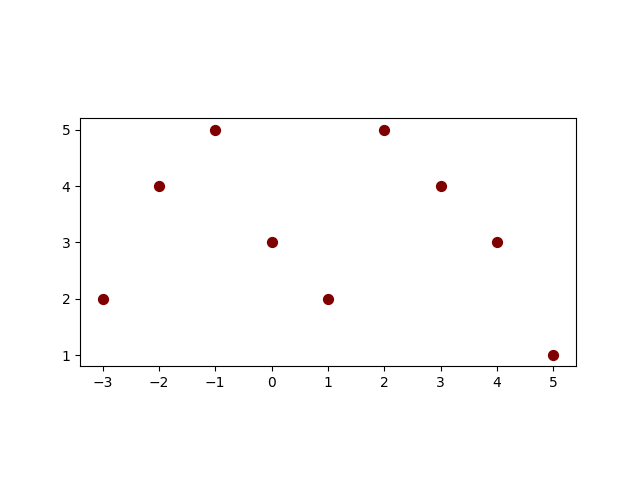

In [9]:
from IPython import display
display.Image("points9.png")

## Let's write a C program that finds the 2d point farthest from the origin.

## Note that this problem is equivalent to maximizing the length of the input vectors.  

## Recall that the length of a vector in $\mathbb{R}^2$ is given by
$$\Large{\| x \| = \sqrt{ x_1^2 + x_2^2}}$$

## Since for positive numbers $x$, $y$ we have that $x^2 > y^2$ if and only if $x > y$, maximizing $\| x \|$ is equivalent to maximizing the length squared:
$$\Large{\| x \|^2 = x_1^2 + x_2^2}$$

## This trick allows us to avoid the use of the *sqrt* function which is expensive to compute.

## Here is a short *proof* of the key result:  Suppose $x > 0$ and $y > 0$.  Then
$$x^2 > y^2 \Leftrightarrow x^2 - y^2 > 0 \Leftrightarrow (x-y)(x+y) > 0 \Leftrightarrow x-y > 0 \Leftrightarrow x > y$$



In [10]:
%%writefile farthest.c
#include <stdio.h>

typedef struct {
    float x,y;
} vec2;

float vec2_len_sq (vec2 v) {
    return v.x*v.x + v.y*v.y;
}

int main () {
    vec2 farthest;
    float max_len_sq = 0;
    vec2 next;
    while (scanf("%f %f",&(next.x),&(next.y)) == 2) {
        float len_sq = vec2_len_sq(next);
        if (len_sq > max_len_sq) {
            max_len_sq = len_sq;
            farthest = next;
        }
    }
    printf ("The point farthest from the origin is (%.2f,%.2f)\n",
            farthest.x,farthest.y);
}

Writing farthest.c


In [11]:
!gcc -o farthest farthest.c

In [12]:
cat points9.txt | ./farthest

The point farthest from the origin is (2.00,5.00)


# Part 3 : Finding the Extreme Pair of Points

## In the next example we wish to find the pair of points that are farthest apart.  

## We will call this pair the **extreme pair**.  

## To find the pair with the maximum distance we will need to maximize
$$\Large{\| u - v \|}$$
## over all possible pairs of points which is equivalent to maximizing
$$\Large{\| u - v \|^2}$$

## Given $n$ points, there are $\binom{n}{2} = \frac{n(n-1)}{2}$ possible pairs of points.  

## A proof of this fact is that you first pick a point (n choices) and then a second point (n-1 choices) but then you have counted each pair twice since (x,y) and (y,x) are the same pair!

## When enumerating all pairs of points we will use the indices $0, 1, 2, ..., n-1$ of the points.   

## We can avoid repeating the pairs by only counting pairs $(i,j)$ such that $i < j$.  

## Note that this approach also avoids counting $(i,i)$ as a pair.

## We will store the 2d points in an **array of structures**.

## We assume that the first line of the datafile contains the number of points.

## Here is a 10 point datafile that includes the number of points in the first line.

In [13]:
%%writefile points10.txt
10
3 4
1 2
-1 5
-2 4
4 3
-3 2
2 5
0 3
5 4
2 1

Writing points10.txt


## We assume that the number of points in the dataset is small so that our array of 2d point structures will easily fit into  stack memory.  

## **Later we will overcome this limitation by storing our datasets on the heap.**

## Note that we also write a function to read in a 2d dataset.

In [14]:
%%writefile extreme.c
#include <stdio.h>
#include <stdlib.h>

typedef struct {
    float x,y;
} vec2;

float vec2_dist_sq (vec2 u, vec2 v) {
    return (u.x-v.x)*(u.x-v.x)+(u.y-v.y)*(u.y-v.y);
}

void vec2_read_dataset (vec2* data, int len) {
    for (int i=0;i<len;i++) {
        if (scanf("%f %f",&(data[i].x),&(data[i].y)) != 2) {
            printf ("error reading dataset\n");
            exit (1);
        }
    }
}

typedef struct {
    float max_dist_sq;
    int extreme_1, extreme_2;
} extreme_info;

extreme_info extreme_pair (vec2* data, int num_points) {
    extreme_info info = { 0, -1, -1 };
    for (int i=0;i<num_points-1;i++) {
        for (int j=i+1;j<num_points;j++) {
            float dist_sq = vec2_dist_sq(data[i],data[j]);
            if (dist_sq > info.max_dist_sq) {
                info.max_dist_sq = dist_sq;
                info.extreme_1 = i;
                info.extreme_2 = j;
            }
        }
    }
    return info;
}

int main () {

    // read dataset
    int len;
    if (scanf("%d",&len) != 1) {
        printf ("error reading the length of the dataset\n");
        return 1;
    }
    vec2 data[len];
    vec2_read_dataset (data,len);

    // find the extreme pair
    extreme_info info;
    info = extreme_pair(data,len);

    // print the results
    printf ("The extreme pair has indices (%d,%d)\n",info.extreme_1,info.extreme_2);
    printf ("The distance squared between the extreme pair is %g\n",info.max_dist_sq);
}

Writing extreme.c


In [15]:
!gcc -o extreme extreme.c

In [16]:
!cat points10.txt | ./extreme

The extreme pair has indices (5,8)
The distance squared between the extreme pair is 68


## Here is a Python script for visualizing the extreme pair.

In [17]:
%%writefile extreme.py
import sys
import numpy as np
import matplotlib.pyplot as plt

# the name of the output file is a command line argument
if (len(sys.argv) < 2):
    print ("Command Usage : python3",sys.argv[0],"outfile")
    exit(1)
outfile = sys.argv[1]

# read the data file
data = np.loadtxt(sys.stdin,skiprows=1)

# plot the data
plt.gca().set_aspect('equal')
plt.scatter(data[:,0],data[:,1],s=50,color='maroon')

# plot the special points (if additional command line argments present)
for k in range(2,len(sys.argv)):
    i = int(sys.argv[k])
    plt.scatter (data[i,0],data[i,1],s=100,color='orange')

# save the plot as an image
plt.savefig(outfile)

Writing extreme.py


In [18]:
!cat points10.txt | python3 extreme.py points10.png 5 8

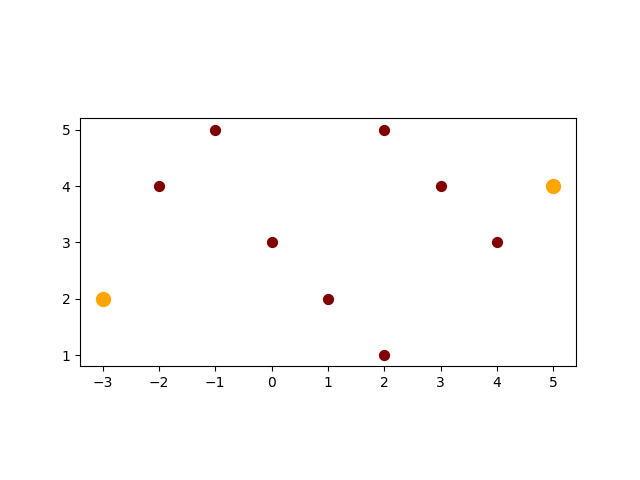

In [19]:
from IPython import display
display.Image("points10.png")

# Part 4 : How are C Structures Passed to Functions?

## The following program does not work as expected.  Why not?  

In [20]:
%%writefile add_v1.c
#include <stdio.h>

typedef struct {
    float x,y;
} vec2;

void vec2_add (vec2 a, vec2 b, vec2 c) {
    c.x = a.x + b.x;
    c.y = a.y + b.y;
}

int main () {
    vec2 u = { 1.0, 2.0 };
    vec2 v = { 2.0, 3.0 };
    vec2 w = { 0, 0 };
    vec2_add(u,v,w);
    printf ("The sum of u and v is (%.2f, %.2f)\n",w.x,w.y);
}

Writing add_v1.c


In [21]:
!gcc -o add_v1 add_v1.c

In [22]:
!./add_v1

The sum of u and v is (0.00, 0.00)


## C passes structures to functions **by value** (i.e. by copy)!

## There is an easy way to fix the problem in this case!

In [23]:
%%writefile add_v2.c
#include <stdio.h>

typedef struct {
    float x,y;
} vec2;

vec2 vec2_add (vec2 a, vec2 b) {
    vec2 c = { a.x + b.x, a.y + b.y };
    return c;
}

int main () {
    vec2 u = { 1.0, 2.0 };
    vec2 v = { 2.0, 3.0 };
    vec2 w = vec2_add(u,v);
    printf ("The sum of u and v is (%.2f, %.2f)\n",w.x,w.y);
}

Writing add_v2.c


In [24]:
!gcc -o add_v2 add_v2.c

In [25]:
!./add_v2

The sum of u and v is (3.00, 5.00)


## However there are some pitfalls to keep in mind when passing C structures by value.  

## Discussion: Why does the following code take so long to run?

In [26]:
%%writefile bigvector_v1.c
#include <stdio.h>

typedef struct {
    float x[200000];
} vec200k;

vec200k vec200k_set (vec200k v, int i, float c) {
    v.x[i] = c;
    return v;
}

int main () {
    vec200k vec;
    for (int i=0;i<200000;i++) {
        vec = vec200k_set (vec,i,i);
    }
    printf ("x[123456] = %.2f",vec.x[123456]);
}

Writing bigvector_v1.c


In [27]:
!gcc -o bigvector_v1 bigvector_v1.c

In [28]:
!time ./bigvector_v1

x[123456] = 123456.00
real	0m26.075s
user	0m20.826s
sys	0m0.126s


# Part 5 : Passing C Structures by Pointer

## Like integers, floats, etc., we can pass C structures to function by pointer.

## Here is a third version of our add function that works as expected.  

## In particular, we pass the third argument by pointer.

## Note that c->x is short for (*c).x

In [29]:
%%writefile add_v3.c
#include <stdio.h>

typedef struct {
    float x,y;
} vec2;

void vec2_add (vec2 a, vec2 b, vec2* c) {
    c->x = a.x + b.x;
    c->y = a.y + b.y;
}

int main () {
    vec2 u = { 1.0, 2.0 };
    vec2 v = { 2.0, 3.0 };
    vec2 w = { 0, 0 };
    vec2_add(u,v,&w);
    printf ("The sum of u and v is (%.2f, %.2f)\n",w.x,w.y);
}

Writing add_v3.c


In [30]:
!gcc -o add_v3 add_v3.c

In [31]:
!./add_v3

The sum of u and v is (3.00, 5.00)


## **Passing large C structures by value in C is rarely a good idea.**

## Instead we should always pass large C structures by pointer for efficiency.  

## Here is version 2 of bigvector that is **drastically** more efficient than version 1.

## In fact, if we pass the large C structure by pointer for efficiency, we do not need the return value since we can modify the structure indirectly through the pointer!

In [32]:
%%writefile bigvector_v2.c
#include <stdio.h>

typedef struct {
    float x[200000];
} vec200k;

void vec200k_set (vec200k* v, int i, float c) {
    v->x[i] = c;
}

int main () {
    vec200k vec;
    for (int i=0;i<200000;i++) {
        vec200k_set (&vec,i,i);
    }
    printf ("x[123456] = %.2f",vec.x[123456]);
}

Writing bigvector_v2.c


In [33]:
!gcc -o bigvector_v2 bigvector_v2.c

In [34]:
!time ./bigvector_v2

x[123456] = 123456.00
real	0m0.005s
user	0m0.001s
sys	0m0.002s
